In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
import sys,os
import rdkit
import networkx as nx
import pandas as pd

In [4]:
structures=pd.read_csv("../input/structures.csv")

In [5]:
structures.head()

molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397

In [6]:
bonds=pd.concat([pd.read_csv("../input/train_bonds.csv",index_col=0),
                 pd.read_csv("../input/test_bonds.csv",index_col=0)]).reset_index()

/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
bonds.head()

index    L2dist  atom_index_0  atom_index_1  error     molecule_name  \
0      0  1.091953             0             1      0  dsgdb9nsd_000001   
1      1  1.091952             0             2      0  dsgdb9nsd_000001   
2      2  1.091946             0             3      0  dsgdb9nsd_000001   
3      3  1.091948             0             4      0  dsgdb9nsd_000001   
4      4  1.017190             0             1      0  dsgdb9nsd_000002   

   nbond bond_type  
0      1       1CH  
1      1       1CH  
2      1       1CH  
3      1       1CH  
4      1       1HN

In [8]:
len(set(structures['molecule_name'])),len(set(bonds['molecule_name'])),structures.shape,bonds.shape

(130775, 130775, (2358657, 6), (2439594, 8))

In [9]:
structures['molecule_name'].value_counts().head()

dsgdb9nsd_122006    29
dsgdb9nsd_122135    29
dsgdb9nsd_123246    29
dsgdb9nsd_123139    29
dsgdb9nsd_102492    29
Name: molecule_name, dtype: int64

In [10]:
set(structures['atom'])

{'C', 'F', 'H', 'N', 'O'}

In [11]:
set(bonds['nbond'])

{1, 2, 3}

In [46]:
dict_atomic_nums={'C':6, 'F':9, 'H':1, 'N':7, 'O':8}
dict_num_bond = {
    1:Chem.rdchem.BondType.SINGLE,
    1.5:Chem.rdchem.BondType.ONEANDAHALF,
    2:Chem.rdchem.BondType.DOUBLE,
    2.5:Chem.rdchem.BondType.TWOANDAHALF,
    3:Chem.rdchem.BondType.TRIPLE,
    3.5:Chem.rdchem.BondType.THREEANDAHALF,
}
def nx_to_mol(G):
    '''
    modified from https://github.com/dakoner/keras-molecules/blob/dbbb790e74e406faa70b13e8be8104d9e938eba2/convert_rdkit_to_networkx.py
    '''
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in sorted(list(G.nodes())):
        a=Chem.Atom(atomic_nums[node])
        if chiral_tags: a.SetChiralTag(chiral_tags[node])
        if formal_charges: a.SetFormalCharge(formal_charges[node])
        if node_is_aromatics: a.SetIsAromatic(node_is_aromatics[node])
        if node_hybridizations: a.SetHybridization(node_hybridizations[node])
        if num_explicit_hss: a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        assert (node==idx)
        node_to_idx[node] = idx
    
    
    bond_types = nx.get_edge_attributes(G, 'bond_type')
    #print (node_to_idx)
    #print (bond_types)

    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        if (first, second) in bond_types:
            bond_type = bond_types[(first, second)]
            #print (first,second,ifirst,isecond,bond_type)
            mol.AddBond(ifirst, isecond, bond_type)

    #Chem.SanitizeMol(mol)
    AllChem.Compute2DCoords(mol)
    xyz = nx.get_node_attributes(G, 'xyz')
    if True and xyz:
        conformer=mol.GetConformer()
        for node in G.nodes():
            idx = node_to_idx[node]
            x,y,z=xyz[node]
            pos=rdkit.Geometry.rdGeometry.Point3D(x,y,z)
            conformer.SetAtomPosition(idx,pos)
    Chem.SanitizeMol(mol)
    return mol

In [13]:
%%time
structures_dict= dict(tuple(structures[:].groupby('molecule_name')))

CPU times: user 16.6 s, sys: 196 ms, total: 16.8 s
Wall time: 16.8 s


In [14]:
structures_dict['dsgdb9nsd_000001']

molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397

In [15]:
%%time
bonds_dict= dict(tuple(bonds[:].groupby('molecule_name')))

CPU times: user 19.1 s, sys: 348 ms, total: 19.5 s
Wall time: 19.5 s


In [16]:
bonds_dict['dsgdb9nsd_000001']

index    L2dist  atom_index_0  atom_index_1  error     molecule_name  \
0      0  1.091953             0             1      0  dsgdb9nsd_000001   
1      1  1.091952             0             2      0  dsgdb9nsd_000001   
2      2  1.091946             0             3      0  dsgdb9nsd_000001   
3      3  1.091948             0             4      0  dsgdb9nsd_000001   

   nbond bond_type  
0      1       1CH  
1      1       1CH  
2      1       1CH  
3      1       1CH

In [43]:
def process_molecule(molecule_name):
    #a=structures[structures['molecule_name']==molecule_name]
    #b=bonds[bonds['molecule_name']==molecule_name]    
    a=structures_dict[molecule_name]
    b=bonds_dict[molecule_name]
    assert len(a)>0 and len(b)>0
    G=nx.Graph()
    G.add_edges_from(b[['atom_index_0','atom_index_1']].values)
    
    attributes={}
    for i in range(len(a)):
        row=a.iloc[i]
        attributes[row['atom_index']]=dict_atomic_nums[row['atom']]
    nx.set_node_attributes(G,attributes, name="atomic_num")
    
    attributes={}
    for i in range(len(b)):
        row=b.iloc[i]

        attributes[(row['atom_index_0'],row['atom_index_1'])]=dict_num_bond[row['nbond']]
    nx.set_edge_attributes(G,attributes, name="bond_type")
    
    attributes={}
    for i in range(len(a)):
        row=a.iloc[i]
        attributes[row['atom_index']]=list(row[['x','y','z']].values)

    nx.set_node_attributes(G,attributes, name="xyz")
    
    #nx.draw(G,with_labels=True)
    
    mol=nx_to_mol(G)
    
    mol.SetProp("_Name",molecule_name)
    return mol


In [18]:
molecule_names = sorted(list(set(structures['molecule_name'])))
len(molecule_names)

130775

In [20]:
str(molecule_names[:4])

"['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003', 'dsgdb9nsd_000004']"

In [24]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize=(600,400)
 
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

In [27]:
bonds[bonds.molecule_name=='dsgdb9nsd_000004']

index    L2dist  atom_index_0  atom_index_1  error     molecule_name  \
1586194      0  1.062099             1             2      0  dsgdb9nsd_000004   
1586195      1  1.062099             0             3      0  dsgdb9nsd_000004   
1586196      2  1.199079             0             1      0  dsgdb9nsd_000004   

         nbond bond_type  
1586194      1       1CH  
1586195      1       1CH  
1586196      3       3CC

In [28]:
structures_dict['dsgdb9nsd_000004']

molecule_name  atom_index atom         x    y    z
12  dsgdb9nsd_000004           0    C  0.599539  0.0  1.0
13  dsgdb9nsd_000004           1    C -0.599539  0.0  1.0
14  dsgdb9nsd_000004           2    H -1.661639  0.0  1.0
15  dsgdb9nsd_000004           3    H  1.661639  0.0  1.0

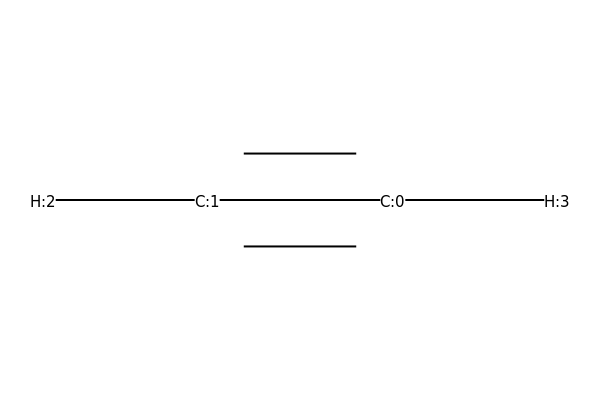

In [47]:
mol_with_atom_index(process_molecule("dsgdb9nsd_000004"))

In [48]:
from tqdm import tqdm_notebook
outfilename="../input/graph2mol.sdf"
status=[]
writer = Chem.SDWriter(outfilename)
for molecule_name in tqdm_notebook(molecule_names):
    has_error=False
    err_msg=""
    try:
        mol = process_molecule(molecule_name)
        writer.write(mol)
        if 0:
            smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
            m = Chem.MolFromSmiles(smiles)
            smiles = Chem.MolToSmiles(m, isomericSmiles=True)
            print(smiles)
    except Exception as  e :
        has_error=True
        err_msg=str(e)
    status.append([molecule_name,has_error,err_msg])
    #break
writer.close()    

In [53]:
import pandas as pd
statusdf= pd.DataFrame(status,columns=['id','has_error','err_msg'])
statusdf['has_error'].sum()


0

In [50]:
#statusdf[statusdf['has_error']].iloc[0]['err_msg']

In [51]:
statusdf.head()

id  has_error err_msg
0  dsgdb9nsd_000001      False        
1  dsgdb9nsd_000002      False        
2  dsgdb9nsd_000003      False        
3  dsgdb9nsd_000004      False        
4  dsgdb9nsd_000005      False

In [52]:
statusdf.to_csv("../input/graph2mol.status.csv",index=None)

# test code

In [15]:
molecule_name='dsgdb9nsd_000038'

In [16]:
mol = process_molecule(molecule_name)

In [17]:
print(Chem.MolToMolBlock(mol))     

dsgdb9nsd_000038
     RDKit          2D

  8  7  0  0  0  0  0  0  0  0999 V2000
    0.1938    1.3717    0.3140 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0172    1.9127   -0.4534 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.0499    0.0141   -0.0453 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6044   -0.2652   -0.9521 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.4674   -0.5752    0.7818 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4089   -0.3964   -0.2060 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1184    0.3008    0.2987 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7773   -1.3723   -0.8036 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  1  3  1  0
  3  4  1  0
  3  5  1  0
  3  6  1  0
  6  7  1  0
  6  8  2  0
M  END



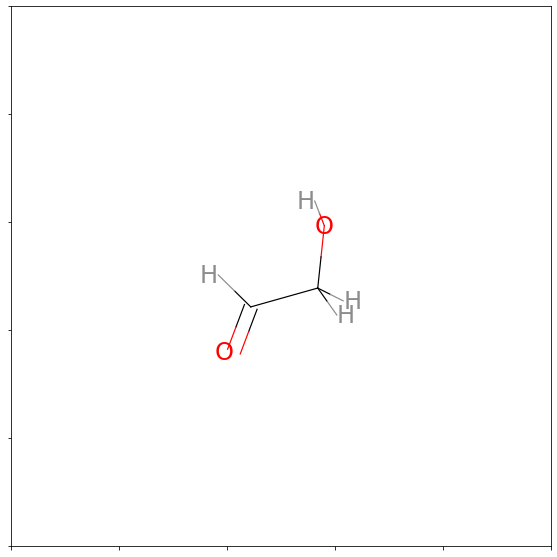

In [165]:
Draw.MolToMPL(mol);

In [149]:
a=structures[structures['molecule_name']==molecule_name]
b=bonds[bonds['molecule_name']==molecule_name]

In [150]:
a

molecule_name  atom_index atom         x         y         z
264  dsgdb9nsd_000038           0    O  0.193759  1.371710  0.313983
265  dsgdb9nsd_000038           1    C  0.049926  0.014055 -0.045262
266  dsgdb9nsd_000038           2    C -1.408880 -0.396357 -0.206016
267  dsgdb9nsd_000038           3    O -1.777295 -1.372339 -0.803617
268  dsgdb9nsd_000038           4    H -0.017232  1.912691 -0.453378
269  dsgdb9nsd_000038           5    H  0.604405 -0.265198 -0.952057
270  dsgdb9nsd_000038           6    H  0.467404 -0.575217  0.781763
271  dsgdb9nsd_000038           7    H -2.118351  0.300760  0.298705

In [151]:
b

index    L2dist  atom_index_0  atom_index_1  error     molecule_name  \
172    172  0.962299             0             4      0  dsgdb9nsd_000038   
173    173  1.098956             1             5      0  dsgdb9nsd_000038   
174    174  1.097952             1             6      0  dsgdb9nsd_000038   
175    175  1.115376             2             7      0  dsgdb9nsd_000038   
176    176  1.411727             0             1      0  dsgdb9nsd_000038   
177    177  1.202247             2             3      0  dsgdb9nsd_000038   
178    178  1.523941             1             2      0  dsgdb9nsd_000038   

     nbond bond_type  
172      1       1HO  
173      1       1CH  
174      1       1CH  
175      1       1CH  
176      1       1CO  
177      2       2CO  
178      1       1CC

In [152]:
G=nx.Graph()

In [153]:
G.add_edges_from(b[['atom_index_0','atom_index_1']].values)

In [154]:
attributes={}
for i in range(len(a)):
    row=a.iloc[i]
    attributes[row['atom_index']]=dict_atomic_nums[row['atom']]

nx.set_node_attributes(G,attributes, name="atomic_num")

In [155]:
attributes={}
for i in range(len(b)):
    row=b.iloc[i]
    
    attributes[(row['atom_index_0'],row['atom_index_1'])]=dict_num_bond[row['nbond']]
nx.set_edge_attributes(G,attributes, name="bond_type")

In [156]:
attributes={}
for i in range(len(a)):
    row=a.iloc[i]
    attributes[row['atom_index']]=list(row[['x','y','z']].values)

nx.set_node_attributes(G,attributes, name="xyz")

In [157]:
list(G.nodes())

[0, 4, 1, 5, 6, 2, 7, 3]

/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


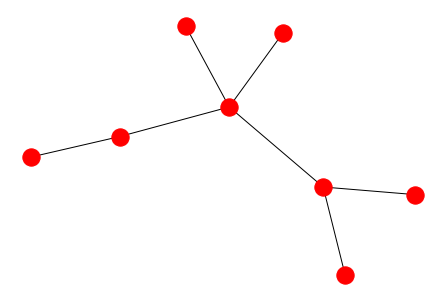

In [158]:
nx.draw(G)

In [159]:
mol=nx_to_mol(G)

In [160]:
print(Chem.MolToMolBlock(mol))     


     RDKit          2D

  8  7  0  0  0  0  0  0  0  0999 V2000
    0.1938    1.3717    0.3140 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0172    1.9127   -0.4534 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.0499    0.0141   -0.0453 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6044   -0.2652   -0.9521 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.4674   -0.5752    0.7818 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4089   -0.3964   -0.2060 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1184    0.3008    0.2987 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7773   -1.3723   -0.8036 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  1  3  1  0
  3  4  1  0
  3  5  1  0
  3  6  1  0
  6  7  1  0
  6  8  2  0
M  END



In [131]:
Chem.MolToSmiles(mol)

'[H]C([H])([H])[H]'

In [129]:
from rdkit.Chem import Draw,AllChem

In [130]:
Draw.MolToMPL(mol);

In [7]:
len(files)

130775

In [9]:
files[0]

'dsgdb9nsd_000001.xyz'

In [11]:
for u in files:
    assert u.endswith(".xyz")

In [18]:
from xyz2mol import     read_xyz_file, xyz2mol


In [24]:
from tqdm import tqdm_notebook

In [40]:
outfilename="../input/xyz2mol.sdf"
status=[]
writer = Chem.SDWriter(outfilename)
for filename in tqdm_notebook(files):
    has_error=False
    err_msg=""
    try:
        atomicNumList, charge, xyz_coordinates = read_xyz_file("../input/structures/"+filename)
        mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments=True, quick=True)
        mol.SetProp("_Name",filename)
        writer.write(mol)
        if 0:
            smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
            m = Chem.MolFromSmiles(smiles)
            smiles = Chem.MolToSmiles(m, isomericSmiles=True)
            print(smiles)
    except Exception as  e :
        has_error=True
        err_msg=str(e)
    status.append([filename,has_error,err_msg])
    #break
writer.close()    

In [42]:
import pandas as pd

In [47]:
statusdf= pd.DataFrame(status,columns=['id','has_error','err_msg'])

In [50]:
statusdf['has_error'].sum()

15

In [56]:
statusdf[statusdf['has_error']].iloc[0]['err_msg']

'Sanitization error: Explicit valence for atom # 4 C greater than permitted'

In [78]:
statusdf.head()

id  has_error err_msg
0  dsgdb9nsd_000001.xyz      False        
1  dsgdb9nsd_000002.xyz      False        
2  dsgdb9nsd_000003.xyz      False        
3  dsgdb9nsd_000004.xyz      False        
4  dsgdb9nsd_000005.xyz      False

In [79]:
statusdf.to_csv("../input/xyz2mol.status.csv",index=None)

In [85]:
print(Chem.MolToMolBlock(mol))  

dsgdb9nsd_133885.xyz
     RDKit          3D

 16 20  0  0  0  0  0  0  0  0999 V2000
   -1.4099    1.3373    0.4100 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5646    0.0991   -0.5169 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8329   -0.7076    0.6043 C   0  0  1  0  0  0  0  0  0  0  0  0
    0.2710   -1.6186    0.1448 C   0  0  2  0  0  0  0  0  0  0  0  0
    1.5285   -0.7551    0.3395 C   0  0  2  0  0  0  0  0  0  0  0  0
    1.2502    0.4586    1.0471 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0574    0.6112    0.5411 C   0  0  2  0  0  0  0  0  0  0  0  0
   -0.0959    0.3804   -0.9721 C   0  0  1  0  0  0  0  0  0  0  0  0
    0.8167   -0.8131   -1.0224 C   0  0  2  0  0  0  0  0  0  0  0  0
   -2.0904    1.3271    1.2637 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4400    2.2872   -0.1275 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4540   -0.9673    1.4592 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.2778   -2.6979    0.1958 H   0  0  0  0  0  0  0  0  0  0  0  0
    2

In [99]:
conformer=mol.GetConformer()
for i in range(16):
    pos = conformer.GetAtomPosition(i) 
    print (pos.x,pos.y,pos.z)
    pos=rdkit.Geometry.rdGeometry.Point3D(i,i,i)
    conformer.SetAtomPosition(i,pos)
    

1.2607453273 -1.246753647 -1.9067671561
-1.5645935686 0.0991248506 -0.5169414085
-0.8328987002 -0.7075502499 0.6042954267
0.2710295071 -1.6186138429 0.1448045117
1.5284535968 -0.7551229418 0.3395081289
1.2502128073 0.4586399968 1.0471189507
-0.0573999238 0.6112101834 0.5411015062
-0.0959285633 0.3804239493 -0.9720975179
0.8166944813 -0.8130667666 -1.0223596478
-2.0904360778 1.3270660878 1.2636607576
-1.4400420103 2.2872179783 -0.1275429128
-1.4540044954 -0.9673087774 1.4592464484
0.2777789004 -2.6978723974 0.1957699995
2.5158540612 -1.1517837735 0.5273692559
0.0136988019 1.1994305695 -1.6801923032
1.2607453273 -1.246753647 -1.9067671561


In [100]:
conformer=mol.GetConformer()
for i in range(16):
    pos = conformer.GetAtomPosition(i) 
    print (pos.x,pos.y,pos.z)
    

0.0 0.0 0.0
1.0 1.0 1.0
2.0 2.0 2.0
3.0 3.0 3.0
4.0 4.0 4.0
5.0 5.0 5.0
6.0 6.0 6.0
7.0 7.0 7.0
8.0 8.0 8.0
9.0 9.0 9.0
10.0 10.0 10.0
11.0 11.0 11.0
12.0 12.0 12.0
13.0 13.0 13.0
14.0 14.0 14.0
15.0 15.0 15.0


In [88]:
a=mol.GetConformer()

In [89]:
a.SetAtomPosition(0,pos)

In [94]:
import rdkit
pos=rdkit.Geometry.rdGeometry.Point3D()

In [97]:
pos.x=3

In [98]:
pos.x

3.0

In [91]:
type(pos)

rdkit.Geometry.rdGeometry.Point3D

(-1.4098766039, 1.3373373609, 0.4099526107)

In [66]:
for u in mol.GetAtoms():
    print (u,u.GetAtomicNum())

<rdkit.Chem.rdchem.QueryAtom object at 0x7f7b8cb49bc0> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 7
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49bc0> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb97800> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 8
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb97800> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb97800> 6
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 1
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb97800> 1
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 1
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb97800> 1
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb49c60> 1
<rdkit.Chem.rdchem.Atom object at 0x7f7b8cb97800> 1
<rdkit.Chem.rdchem.Atom object at 0x7f7b8ce48260> 1


In [69]:
Chem.MolToSmiles(mol, isomericSmiles=True)

'[H]C1([H])N2[C@]3([H])[C@]14O[C@]1([H])[C@]([H])([C@@]24[H])[C@]31[H]'

In [70]:
Chem.MolToSmiles(mol, isomericSmiles=False)

'[H]C1([H])N2C3([H])C4([H])C5([H])OC13C2([H])C54[H]'

In [72]:
for u in mol.GetBonds():
    print (u)

In [73]:
u.GetBondType()

rdkit.Chem.rdchem.BondType.SINGLE

In [77]:
type(Chem.rdchem.BondType.SINGLE)

rdkit.Chem.rdchem.BondType

In [75]:
dir(Chem.rdchem.BondType)

['AROMATIC',
 'DATIVE',
 'DATIVEL',
 'DATIVEONE',
 'DATIVER',
 'DOUBLE',
 'FIVEANDAHALF',
 'FOURANDAHALF',
 'HEXTUPLE',
 'HYDROGEN',
 'IONIC',
 'ONEANDAHALF',
 'OTHER',
 'QUADRUPLE',
 'QUINTUPLE',
 'SINGLE',
 'THREEANDAHALF',
 'THREECENTER',
 'TRIPLE',
 'TWOANDAHALF',
 'UNSPECIFIED',
 'ZERO',
 '__abs__',
 '__add__',
 '__and__',
 '__bool__',
 '__ceil__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__

In [67]:
from rdkit.Chem import Draw

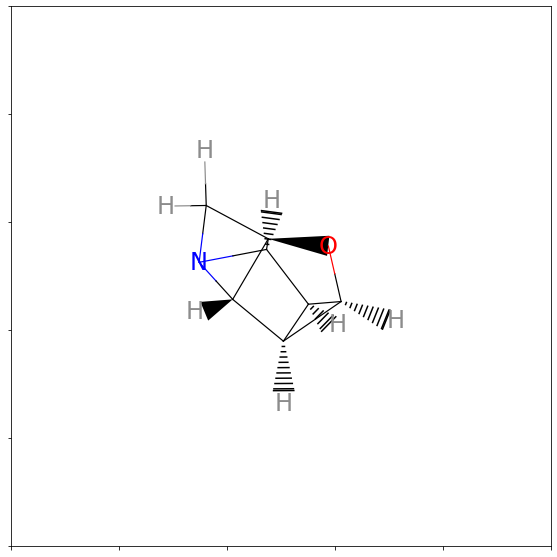

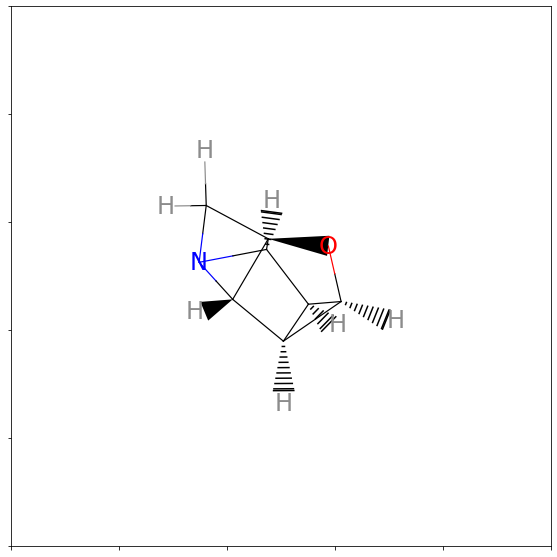

In [68]:
Draw.MolToMPL(mol)